In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta # These help with dates, so we can fetch data up to today or calculate past ranges.
import yfinance as yf  # This imports the yfinance library, which lets us download stock/crypto data from Yahoo Finance easily.

In [3]:
ticker = 'BTC-USD'
# Calculate the start date: 5 years ago from today, for plenty of training data.
end_date = datetime.now()  # Gets today's date and time.
start_date = '2018-01-01'

# Download the historical data.
data = yf.download(ticker, start=start_date, end=end_date)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)
# Reset the index so 'Date' becomes a column (easier to work with).
data.reset_index(inplace=True)  # Moves the date from the index to a regular column without creating a copy.
# Show the first few rows to check.
data.head() # Prints the top 5 rows, so you can see what the data looks like (dates, prices).

C:\Users\Shahin\AppData\Local\Temp\ipykernel_9244\2414050518.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


In [4]:
# Check for missing values
data.isnull().sum()  # This checks each column for null (missing) values with isnull(), sums them per column with sum(), and prints.

Price
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [5]:
data.describe()

Price,Date,Close,High,Low,Open,Volume
count,2847,2847.000000,2847.000000,2847.000000,2847.000000,2.847000e+03
mean,2021-11-24 00:00:30.347734272,35730.555218,36414.541337,34943.692215,35698.849341,2.945567e+10
min,2018-01-01 00:00:00,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,2019-12-13 12:00:00,9349.504883,9526.112305,9210.088867,9347.785645,1.492804e+10
50%,2021-11-24 00:00:00,26754.281250,27092.697266,26339.314453,26737.578125,2.575241e+10
75%,2023-11-05 12:00:00,54006.605469,55492.714844,52505.458984,53970.216797,3.869125e+10
max,2025-10-18 00:00:00,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11
std,NaN,31145.417393,31631.406015,30581.596318,31118.980990,2.142003e+10


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2847 non-null   datetime64[ns]
 1   Close   2847 non-null   float64       
 2   High    2847 non-null   float64       
 3   Low     2847 non-null   float64       
 4   Open    2847 non-null   float64       
 5   Volume  2847 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 133.6 KB


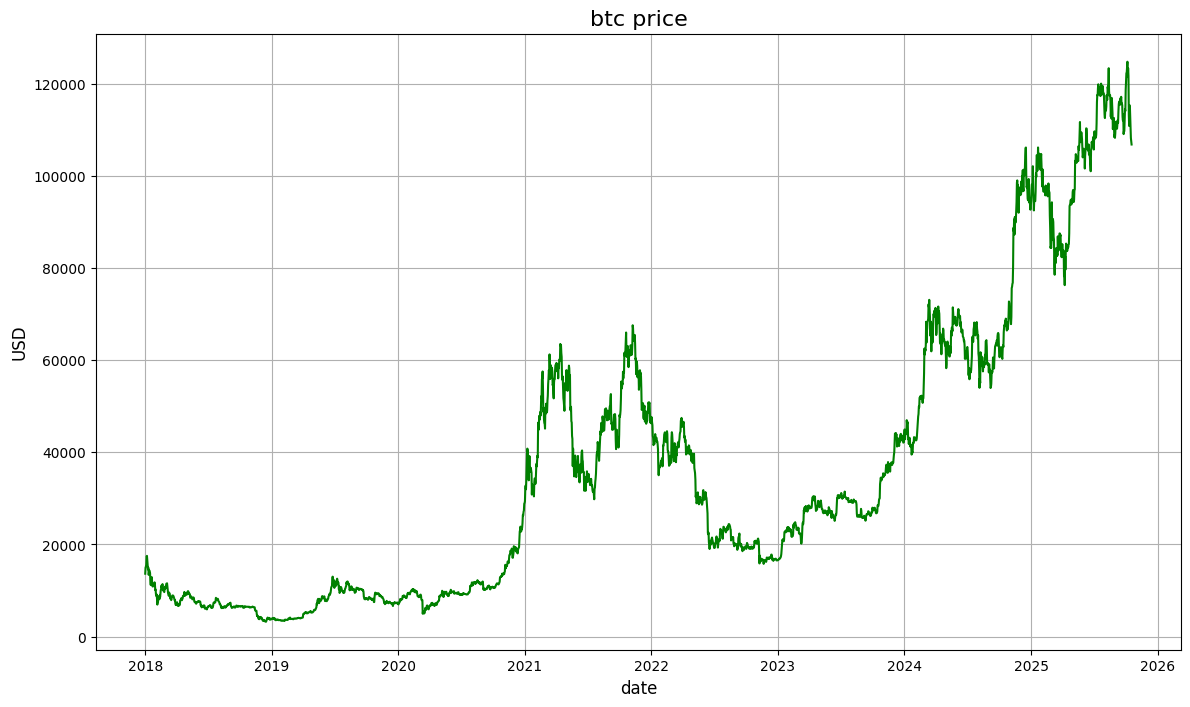

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], data['Close'], color='green')
plt.title('btc price', fontsize=16)
plt.xlabel('date', fontsize=12)
plt.ylabel('USD', fontsize=12)
plt.grid(True)

In [8]:
data.to_csv('data/bitcoin_data.csv')  # This saves 'data' as a CSV file in a new 'data' folder (create it first: right-click project > New > Directory > "data"). The '../' goes up one folder level if needed—adjust if your structure differs.

# **Modeling**

In [9]:
# This splits data into training (to learn) and testing (to check) sets randomly, but we'll adapt for time-series.
from sklearn.model_selection import train_test_split
# These calculate errors: MSE for squared differences, MAPE for percentage errors.
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Imports XGBoost for the ML model—it's a boosted tree algorithm that learns from mistakes.
import xgboost as xgb
# This scales data to 0-1 range, helping models (especially LSTM) converge faster without big numbers dominating.
from sklearn.preprocessing import MinMaxScaler
# TensorFlow for building the LSTM neural network.
import tensorflow as tf
# Sequential lets us stack LSTM layers simply.
from tensorflow.keras.models import Sequential
# LSTM layer for sequence memory, Dense for output.
from tensorflow.keras.layers import LSTM, Dense

In [10]:
# Create lag features: Use past 7 days' Close prices to predict the next day's Close.
# Number of past days as features—matches our 7-day forecast goal.
lags = 7
# Loop from 1 to 7.
for i in range(1, lags + 1):
    # Shifts 'Close' back by i days and adds as new column (e.g., Close_lag_1 is yesterday's price).
    data[f'Close_lag_{i}'] = data['Close'].shift(i)

# Drop rows with NaN (missing) from lags—first 7 rows will have them.
# Removes rows with any missing values; inplace=True updates data directly.
data.dropna(inplace=True)
data

Price,Date,Close,High,Low,Open,Volume,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7
7,2018-01-08,15170.099609,16537.900391,14208.200195,16476.199219,18413899776,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,13657.200195
8,2018-01-09,14595.400391,15497.500000,14424.000000,15123.700195,16659999744,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609
9,2018-01-10,14973.299805,14973.299805,13691.200195,14588.500000,18500800512,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000
10,2018-01-11,13405.799805,15018.799805,13105.900391,14968.200195,16534099968,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195
11,2018-01-12,13980.599609,14229.900391,13158.099609,13453.900391,12065699840,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842,2025-10-13,115271.078125,116020.484375,113821.187500,115161.679688,71582026739,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812,124752.531250
2843,2025-10-14,113118.664062,115502.882812,110029.484375,115264.882812,92212917403,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812
2844,2025-10-15,110783.164062,113622.382812,110235.835938,113113.968750,72574132855,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188
2845,2025-10-16,108186.039062,111990.812500,107537.031250,110782.171875,87306423067,110783.164062,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938


In [11]:
# Features (X): Lag columns + Volume (extra info for patterns).
# Selects lag columns and Volume as input features.
X = data[[f'Close_lag_{i}' for i in range(1, lags + 1)] + ['Volume']]
X

Price,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume
7,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,13657.200195,18413899776
8,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,16659999744
9,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,18500800512
10,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,16534099968
11,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,12065699840
...,...,...,...,...,...,...,...,...
2842,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812,124752.531250,71582026739
2843,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812,92212917403
2844,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,72574132855
2845,110783.164062,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,87306423067


In [12]:
# Target (y): The 'Close' price to predict.
# This is what we want to forecast.
y = data['Close']
y

7        15170.099609
8        14595.400391
9        14973.299805
10       13405.799805
11       13980.599609
            ...      
2842    115271.078125
2843    113118.664062
2844    110783.164062
2845    108186.039062
2846    106789.031250
Name: Close, Length: 2840, dtype: float64

In [13]:
len(data)

2840

In [14]:
int(len(data)*0.8)

2272

In [15]:
# Split: 80% train, 20% test—time-series way (chronological, not random).
# Calculates 80% point as integer.
split_index = int(len(data) * 0.8)
# First 80% for train features, last 20% for test.
X_train, X_test = X[:split_index], X[split_index:]
# Same for targets.
y_train, y_test = y[:split_index], y[split_index:]

In [16]:
X_train

Price,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume
7,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,13657.200195,18413899776
8,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,14982.099609,16659999744
9,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,15201.000000,18500800512
10,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,15599.200195,16534099968
11,13405.799805,14973.299805,14595.400391,15170.099609,16477.599609,17527.000000,17429.500000,12065699840
...,...,...,...,...,...,...,...,...
2274,64062.203125,63778.761719,65491.390625,67913.671875,61912.773438,67548.593750,68390.625000,27206630673
2275,67234.171875,64062.203125,63778.761719,65491.390625,67913.671875,61912.773438,67548.593750,42700139523
2276,69958.812500,67234.171875,64062.203125,63778.761719,65491.390625,67913.671875,61912.773438,36010437368
2277,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719,65491.390625,67913.671875,40827113309


In [17]:
X_test

Price,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume
2279,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719,25230851763
2280,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,17130241883
2281,69645.304688,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,20050941373
2282,71333.648438,69645.304688,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,34873527352
2283,69702.148438,71333.648438,69645.304688,69892.828125,70744.953125,69455.343750,69987.835938,50705240709
...,...,...,...,...,...,...,...,...
2842,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812,124752.531250,71582026739
2843,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,121451.382812,92212917403
2844,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,123354.867188,72574132855
2845,110783.164062,113118.664062,115271.078125,115169.765625,110807.882812,113214.367188,121705.585938,87306423067


In [18]:
y_train

7       15170.099609
8       14595.400391
9       14973.299805
10      13405.799805
11      13980.599609
            ...     
2274    67234.171875
2275    69958.812500
2276    69987.835938
2277    69455.343750
2278    70744.953125
Name: Close, Length: 2272, dtype: float64

In [19]:
y_test

2279     69892.828125
2280     69645.304688
2281     71333.648438
2282     69702.148438
2283     65446.972656
            ...      
2842    115271.078125
2843    113118.664062
2844    110783.164062
2845    108186.039062
2846    106789.031250
Name: Close, Length: 568, dtype: float64

In [20]:
# Scale features and target to 0-1 for better model performance.
# Creates a scaler for features.
scaler_X = MinMaxScaler()
# Fits (learns range) and transforms train features to 0-1.
X_train_scaled = scaler_X.fit_transform(X_train)
# Transforms test using train's range (no peeking!).
X_test_scaled = scaler_X.transform(X_test)

In [21]:
X_train_scaled

array([[0.18956988, 0.20459421, 0.2031983 , ..., 0.16815872, 0.14919005,
        0.04450649],
       [0.17085032, 0.18956988, 0.20459421, ..., 0.17129273, 0.16815872,
        0.03946719],
       [0.16262232, 0.17085032, 0.18956988, ..., 0.17699378, 0.17129273,
        0.04475618],
       ...,
       [0.95526366, 0.91625481, 0.87084154, ..., 0.92598326, 0.84006803,
        0.09506482],
       [0.95567919, 0.95526366, 0.91625481, ..., 0.89130331, 0.92598326,
        0.10890409],
       [0.94805547, 0.95567919, 0.95526366, ..., 0.8667835 , 0.89130331,
        0.0903656 ]], shape=(2272, 8))

In [22]:
y_train.values

array([15170.09960938, 14595.40039062, 14973.29980469, ...,
       69987.8359375 , 69455.34375   , 70744.953125  ], shape=(2272,))

In [23]:
y_train.values.reshape(-1,1)

array([[15170.09960938],
       [14595.40039062],
       [14973.29980469],
       ...,
       [69987.8359375 ],
       [69455.34375   ],
       [70744.953125  ]], shape=(2272, 1))

In [24]:
# Separate scaler for target.
scaler_y = MinMaxScaler()
# Reshapes to 2D (needed), fits/transforms train target.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# Transforms test target.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [25]:
y_train_scaled

array([[0.17085032],
       [0.16262232],
       [0.16803273],
       ...,
       [0.95567919],
       [0.94805547],
       [0.96651888]], shape=(2272, 1))

In [26]:
X_train_scaled.shape

(2272, 8)

In [27]:
X_train_scaled.shape[0]

2272

In [28]:
lags

7

In [29]:
# Reshape for LSTM: [samples, lags, features]—here features=1 (just Close lags, we'll simplify).
# samples = 2271 , lags = 7 , features = 1
# Takes first 7 columns (lags), reshapes to 3D.
X_train_lstm = X_train_scaled[:, :lags].reshape((X_train_scaled.shape[0], lags, 1))
# Same for test (excludes Volume for LSTM simplicity).
X_test_lstm = X_test_scaled[:, :lags].reshape((X_test_scaled.shape[0], lags, 1))

**Explanation: LSTM expects sequences, so we reshape lags into "time steps." We skip Volume here to keep it basic—LSTM focuses on price sequence.**

In [30]:
X_train_lstm

array([[[0.18956988],
        [0.20459421],
        [0.2031983 ],
        ...,
        [0.17129273],
        [0.16815872],
        [0.14919005]],

       [[0.17085032],
        [0.18956988],
        [0.20459421],
        ...,
        [0.17699378],
        [0.17129273],
        [0.16815872]],

       [[0.16262232],
        [0.17085032],
        [0.18956988],
        ...,
        [0.2031983 ],
        [0.17699378],
        [0.17129273]],

       ...,

       [[0.95526366],
        [0.91625481],
        [0.87084154],
        ...,
        [0.89130331],
        [0.92598326],
        [0.84006803]],

       [[0.95567919],
        [0.95526366],
        [0.91625481],
        ...,
        [0.8667835 ],
        [0.89130331],
        [0.92598326]],

       [[0.94805547],
        [0.95567919],
        [0.95526366],
        ...,
        [0.87084154],
        [0.8667835 ],
        [0.89130331]]], shape=(2272, 7, 1))

# **Building the Baseline Model**

In [31]:
y_train

7       15170.099609
8       14595.400391
9       14973.299805
10      13405.799805
11      13980.599609
            ...     
2274    67234.171875
2275    69958.812500
2276    69987.835938
2277    69455.343750
2278    70744.953125
Name: Close, Length: 2272, dtype: float64

In [32]:
y_train.iloc[-1]

np.float64(70744.953125)

In [33]:
# Baseline predictions: Repeat the last train value for all test points.
# Creates array same shape as y_test, filled with last train Close.
baseline_preds = np.full_like(y_test, y_train.iloc[-1])

# We'll evaluate in Phase 4, but peek:
# Shows what it predicts (same for all).
print("Baseline sample pred:", baseline_preds[0])

Baseline sample pred: 70744.953125


In [34]:
baseline_preds

array([70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.953125,
       70744.953125, 70744.953125, 70744.953125, 70744.

In [35]:
baseline_preds.shape

(568,)

**Explanation: This is our "no-brainer" model—if XGBoost/LSTM beat it, they're learning something useful.**

# **Building XGBoost Model**

In [36]:
# Create and train XGBoost regressor.
# This imports GridSearchCV, which tests different hyperparameter combos and finds the best based on performance.

from sklearn.model_selection import GridSearchCV
# Define the model without fitting yet.
# Same as before, but we remove fixed values to tune them.

#model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Set up hyperparameters to try: A small grid for beginners (not too many to avoid long runtime).
# This dictionary lists options—GridSearch will try all combos (5x4x5=100).

#param_grid = {
#    'n_estimators': [100, 200, 400, 600, 800],  # Number of trees: More can capture patterns but risks overfitting.
#    'learning_rate': [0.0001, 0.001, 0.01, 0.1],  # Step size: Smaller is slower but more accurate.
#    'max_depth': [15, 25, 35, 45, 60]  # Tree depth: Deeper trees learn complex patterns, but too deep overfits.
#}

# Run Grid Search: Fits the model multiple times and picks the best.
# 'cv=3' splits train data into 3 folds for testing; 'scoring' uses MSE (negative for maximization).

#grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')


# Fits on scaled train data—might take 1-2 minutes.
#grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best model and print best params for learning.
# This grabs the tuned model.

#model_xgb = grid_search.best_estimator_


# Prints the winning combo, e.g., {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 15}.


#print("Best XGBoost params:", grid_search.best_params_)

**I ran the code above and it took 8m 12s for me (based on my sys capability) and it gave me:**

Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 400}

You could change the hyperparameter to get the better result.



In [37]:
# Create and train XGBoost regressor.
# Sets goal (minimize squared error), 100 trees, slow learning for accuracy.
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, learning_rate=0.01, max_depth=15)
# Trains on scaled train data.
model_xgb.fit(X_train_scaled, y_train_scaled)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [38]:
# Predict on test.
# Gets scaled predictions.
xgb_preds_scaled = model_xgb.predict(X_test_scaled)
 # Inverts scaling to dollars, flattens to 1D.
xgb_preds = scaler_y.inverse_transform(xgb_preds_scaled.reshape(-1, 1)).flatten()

In [39]:
xgb_preds

array([68294.98 , 68285.91 , 67687.625, 67652.39 , 69489.49 , 66103.56 ,
       64803.387, 66127.414, 65795.3  , 68169.03 , 68064.52 , 68583.43 ,
       67696.695, 68072.305, 67991.18 , 68130.125, 66822.44 , 63651.887,
       63265.97 , 64083.848, 60955.94 , 61224.215, 64663.094, 64939.19 ,
       63093.242, 63462.87 , 64949.22 , 65380.906, 63953.062, 63714.258,
       64757.336, 61914.7  , 64580.37 , 60842.18 , 56505.566, 58010.1  ,
       60252.75 , 61869.207, 62336.7  , 60995.195, 61345.547, 60479.25 ,
       60558.34 , 61039.586, 59298.223, 60786.87 , 61712.27 , 61796.383,
       63199.207, 63378.195, 64510.773, 64944.664, 64653.074, 66190.46 ,
       68352.984, 68699.55 , 67169.58 , 68107.54 , 67402.586, 67940.84 ,
       67652.39 , 67133.266, 66916.43 , 66672.91 , 66663.836, 66871.05 ,
       67117.49 , 68352.984, 67700.12 , 68360.76 , 68116.61 , 68107.54 ,
       67687.625, 67643.31 , 67652.39 , 66734.336, 66880.12 , 65368.363,
       65359.29 , 64059.113, 65321.06 , 65211.605, 

In [40]:
xgb_preds.shape

(568,)

# **Building LSTM Model**

In [41]:
# Build LSTM model.
# This imports Dropout, which randomly drops neurons during training to prevent overfitting (model memorizing train data instead of learning general patterns).
from tensorflow.keras.layers import Dropout
# This imports EarlyStopping, a callback that stops training if validation loss doesn't improve, saving time and preventing overfitting.
from tensorflow.keras.callbacks import EarlyStopping

# Now takes dropout_rate (default 0.2=20% neurons dropped) for regularization.
def build_lstm_model(layers, units, dropout_rate=0.2):
    model = Sequential()  # Starts a new sequential model, like stacking blocks.
    for i in range(layers):  # Loop to add the specified number of LSTM layers.
        if i == 0:  # For the first layer:
            # Adds LSTM: 'units' neurons for capacity, return_sequences=True if more layers (passes memory forward), input_shape matches our 3D data (7 lags, 1 feature).
            model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(lags, 1)))
        else:  # For additional layers:
            # Adds more LSTM: Same units, return_sequences only if not the last (final one outputs single value).
            model.add(LSTM(units, return_sequences=(i < layers - 1)))
            # Adds Dropout after each LSTM: Randomly ignores 'dropout_rate' fraction of neurons, helps model generalize to new data like future prices.
        model.add(Dropout(dropout_rate))
    # Adds the output Dense layer: 1 neuron to predict a single value (next Close price).
    model.add(Dense(1))
    # Compiles: 'adam' optimizer adjusts weights efficiently, 'mean_squared_error' loss measures how far predictions are from actual
    # (squared to penalize big errors more).
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Returns the built model for training.
    return model

In [42]:
# Expanded configs to test: More options for better accuracy.
# List of dicts—testing finds a sweeter spot without too much time.

configs = [
    {'layers': 1, 'units': 50, 'dropout_rate': 0.2},  # Basic: 1 layer, medium units, some dropout.
    {'layers': 2, 'units': 50, 'dropout_rate': 0.2},  # Deeper: 2 layers for better long-term memory.
    {'layers': 3, 'units': 50, 'dropout_rate': 0.3},  # Even deeper: 3 layers, higher dropout to handle complexity.
    {'layers': 2, 'units': 100, 'dropout_rate': 0.2},  # Wider: More units for capacity, standard dropout.
    {'layers': 1, 'units': 100, 'dropout_rate': 0.1},   # Simpler wide: Fewer dropouts for faster learning.
    {'layers': 3, 'units': 100, 'dropout_rate': 0.1},    # Some random teak
    {'layers': 3, 'units': 100, 'dropout_rate': 0.2},    # Some random teak
    {'layers': 3, 'units': 100, 'dropout_rate': 0.3},    # Some random teak
    {'layers' : 2, 'units': 200, 'dropout_rate': 0.1}     #Some random teak
]

# Variable to hold the winning model.
best_model = None
 # Starts with infinite loss; we'll update to the lowest found.
best_loss = float('inf')
# Sets up early stopping: Watches val_loss, waits 10 epochs if no improvement, restores best weights.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Loop through each config to test.
for config in configs:
    # Prints progress so you see what's happening.
    print(f"Training LSTM with {config['layers']} layers, {config['units']} units, dropout {config['dropout_rate']}...")

    # Builds the model variant using the function.
    model = build_lstm_model(config['layers'], config['units'], config['dropout_rate'])
    # Trains: Up to 150 epochs (more for better learning), larger batch_size=64
    # (faster on bigger data), 10% validation, early_stop callback, verbose=1 shows progress bars.

    history = model.fit(X_train_lstm, y_train_scaled, epochs=150, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=1)

    # Gets the lowest validation loss from training history (best point before stopping).
    val_loss = min(history.history['val_loss'])
    print(f"Config {config}: Best val loss = {val_loss}")

    if val_loss < best_loss:  # If this loss is better (lower) than previous best:
        best_loss = val_loss  # Update the best loss value.
        best_model = model  # Save this model as the winner.


Training LSTM with 1 layers, 50 units, dropout 0.2...


D:\Python\btc-price-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0208 - val_loss: 0.0046
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 9.2458e-04
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017 - val_loss: 8.9909e-04
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 9.7374e-04
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 8.3797e-04
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 8.7026e-04
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 7, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,105 (2.31 MB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,404 (1.54 MB)

In [44]:
# Use the best for predictions.
# Assigns the best model to our variable.
model_lstm = best_model
# Makes predictions on test data (scaled).
lstm_preds_scaled = model_lstm.predict(X_test_lstm)
# Inverts scaling to get real dollar prices, flattens to a simple list.
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled).flatten()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [45]:
lstm_preds

array([ 69261.914,  69604.06 ,  69679.53 ,  70070.14 ,  69953.   ,
        68750.24 ,  67849.625,  67778.6  ,  67640.984,  67876.39 ,
        68268.555,  69221.73 ,  69357.71 ,  69734.88 ,  69845.89 ,
        69156.664,  67658.35 ,  66885.6  ,  65726.51 ,  64970.78 ,
        63810.363,  63560.58 ,  63580.33 ,  63979.152,  64335.785,
        65149.504,  65689.69 ,  65517.47 ,  65322.402,  64921.25 ,
        64478.48 ,  64049.5  ,  63930.25 ,  63069.04 ,  61756.14 ,
        60914.105,  61290.13 ,  61992.938,  62706.418,  63103.207,
        63175.625,  62824.258,  62909.52 ,  62365.957,  61933.22 ,
        61795.22 ,  62120.79 ,  62082.633,  63292.805,  64046.54 ,
        65108.906,  65876.75 ,  66228.38 ,  67737.484,  68580.43 ,
        68906.87 ,  68779.68 ,  68725.5  ,  68815.27 ,  68671.91 ,
        68775.88 ,  68632.1  ,  68334.805,  68279.305,  68011.586,
        67856.9  ,  67768.54 ,  67992.27 ,  68662.51 ,  69360.21 ,
        69830.164,  69803.93 ,  69687.71 ,  69614.59 ,  69489.

# **Visualization**

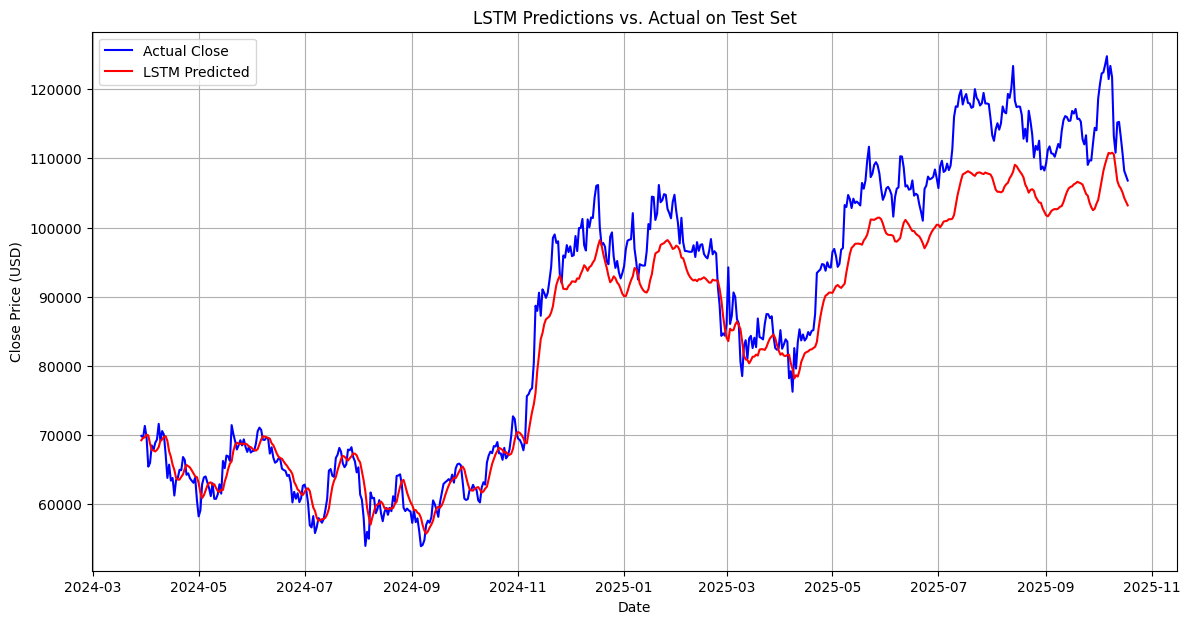

In [46]:
# Plot actual vs. predicted for LSTM on test set.

plt.figure(figsize=(14, 7))  # Creates a new figure (plot window) with width 14, height 7— good size for time-series.
plt.plot(data['Date'].iloc[split_index:], y_test, label='Actual Close', color='blue')  # Plots the dates from test start onward (iloc[split_index:] slices the test dates), with actual y_test prices in blue; label adds a legend entry.

plt.plot(data['Date'].iloc[split_index:], lstm_preds, label='LSTM Predicted', color='red')  # Same dates, but with LSTM predictions in red.

plt.title('LSTM Predictions vs. Actual on Test Set')  # Adds a title to the plot for clarity.
plt.xlabel('Date')  # Labels the x-axis as 'Date'.
plt.ylabel('Close Price (USD)')  # Labels the y-axis as price in USD.
plt.legend()  # Shows the legend (Actual vs. Predicted).
plt.grid(True)  # Adds a grid for easier reading.

# **# Model Metrics**

In [47]:
y_test

2279     69892.828125
2280     69645.304688
2281     71333.648438
2282     69702.148438
2283     65446.972656
            ...      
2842    115271.078125
2843    113118.664062
2844    110783.164062
2845    108186.039062
2846    106789.031250
Name: Close, Length: 568, dtype: float64

In [49]:
# Get the original (unscaled) y_test for comparison—models predict scaled, but we want dollar errors.
# Inverses the scaling on y_test_scaled back to real USD prices; flatten() makes it a simple list.
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled).flatten()

In [51]:
y_test_scaled

array([[0.95431896],
       [0.95077515],
       [0.97494727],
       [0.95158898],
       [0.89066737],
       [0.89831039],
       [0.93450437],
       [0.92489471],
       [0.94004887],
       [0.946727  ],
       [0.97920961],
       [0.94352658],
       [0.9642701 ],
       [0.95672109],
       [0.9157064 ],
       [0.86739499],
       [0.89484443],
       [0.86173601],
       [0.86725741],
       [0.8309612 ],
       [0.86297505],
       [0.86771136],
       [0.88418846],
       [0.8832178 ],
       [0.91057821],
       [0.90441606],
       [0.87391535],
       [0.87684761],
       [0.86644788],
       [0.86163478],
       [0.85725504],
       [0.8676763 ],
       [0.82180063],
       [0.78768531],
       [0.80013288],
       [0.85405669],
       [0.86839719],
       [0.87039671],
       [0.85795255],
       [0.84611044],
       [0.82969056],
       [0.85634921],
       [0.82403298],
       [0.82404634],
       [0.83341949],
       [0.85422296],
       [0.83491411],
       [0.902

In [50]:
y_test_unscaled

array([ 69892.828125  ,  69645.3046875 ,  71333.6484375 ,  69702.1484375 ,
        65446.97265625,  65980.8125    ,  68508.84375   ,  67837.640625  ,
        68896.109375  ,  69362.5546875 ,  71631.359375  ,  69139.015625  ,
        70587.8828125 ,  70060.609375  ,  67195.8671875 ,  63821.47265625,
        65738.7265625 ,  63426.2109375 ,  63811.86328125,  61276.69140625,
        63512.75390625,  63843.5703125 ,  64994.44140625,  64926.64453125,
        66837.6796875 ,  66407.2734375 ,  64276.8984375 ,  64481.70703125,
        63755.3203125 ,  63419.140625  ,  63113.23046875,  63841.12109375,
        60636.85546875,  58254.01171875,  59123.43359375,  62889.8359375 ,
        63891.47265625,  64031.1328125 ,  63161.94921875,  62334.81640625,
        61187.94140625,  63049.9609375 ,  60792.77734375,  60793.7109375 ,
        61448.39453125,  62901.44921875,  61552.7890625 ,  66267.4921875 ,
        65231.58203125,  67051.875     ,  66940.8046875 ,  66278.3671875 ,
        71448.1953125 ,  

In [52]:
# Function to calculate metrics: Makes it easy to use for any model.
# Takes two arrays: actual prices (y_test_unscaled) and model's predictions.
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)  # Computes MSE: Averages (actual - predicted)^2 over all test points—high if big errors.
    rmse = np.sqrt(mse)  # Computes RMSE: Takes square root of MSE—now in USD, like "average error of $X per prediction."
    mape = mean_absolute_percentage_error(actual, predicted) * 100  # Computes MAPE: Averages |actual - predicted| / |actual|, times 100 for percentage—shows relative error, good for comparing across price scales.
    return mse, rmse, mape  # Returns the three values so we can print or use them.

In [53]:
# Baseline metrics: Use baseline_preds from earlier.
baseline_mse, baseline_rmse, baseline_mape = calculate_metrics(y_test_unscaled, baseline_preds)  # Calls the function with actual test prices and baseline predictions.
print(f"Baseline: MSE={baseline_mse:.2f}, RMSE={baseline_rmse:.2f} USD, MAPE={baseline_mape:.2f}%")  # Prints with 2 decimals—e.g., RMSE=5000 means average $5k error.

Baseline: MSE=693674312.77, RMSE=26337.70 USD, MAPE=22.41%


In [54]:
# XGBoost metrics: Use xgb_preds from earlier.
xgb_mse, xgb_rmse, xgb_mape = calculate_metrics(y_test_unscaled, xgb_preds)  # Same call for XGBoost.
print(f"XGBoost: MSE={xgb_mse:.2f}, RMSE={xgb_rmse:.2f} USD, MAPE={xgb_mape:.2f}%")  # Print results.

XGBoost: MSE=776145142.39, RMSE=27859.38 USD, MAPE=20.71%


In [56]:
# LSTM metrics: Use lstm_preds from your tuned model.
lstm_mse, lstm_rmse, lstm_mape = calculate_metrics(y_test_unscaled, lstm_preds)  # Same for LSTM.
print(f"LSTM: MSE={lstm_mse:.2f}, RMSE={lstm_rmse:.2f} USD, MAPE={lstm_mape:.2f}%")  # Print results.

LSTM: MSE=33365106.01, RMSE=5776.25 USD, MAPE=4.68%


# **Metrics Visualization**

In [57]:
# Dictionary to compare RMSE (easiest metric)—lower is better.
# Stores model names and their RMSE values.
metrics_dict = {
    'Baseline': baseline_rmse,  # Adds baseline RMSE.
    'XGBoost': xgb_rmse,  # Adds XGBoost.
    'LSTM': lstm_rmse  # Adds LSTM.
}
# Finds the model with the smallest (min) RMSE; 'key' tells it to use the values.
best_model_name = min(metrics_dict, key=metrics_dict.get)

# Prints the winner—use this in Streamlit.
print(f"Best model overall: {best_model_name} with RMSE {metrics_dict[best_model_name]:.2f} USD")

Best model overall: LSTM with RMSE 5776.25 USD


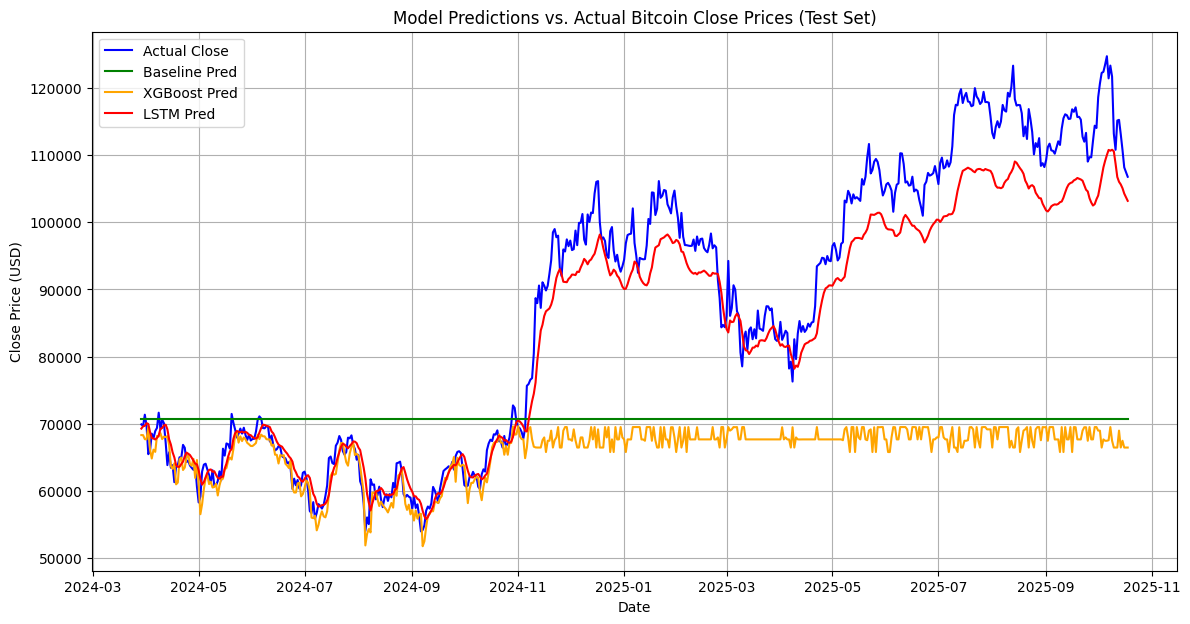

In [58]:
# Plot all predictions vs. actual to see visually.
plt.figure(figsize=(14, 7))  # Creates a plot window, 14 wide by 7 tall—good for time-series.

# Plots test dates (from split_index on) vs. actual prices in blue; label for legend.
plt.plot(data['Date'].iloc[split_index:], y_test_unscaled, label='Actual Close', color='blue')

# Adds baseline predictions in green.
plt.plot(data['Date'].iloc[split_index:], baseline_preds, label='Baseline Pred', color='green')

# Adds XGBoost in orange.
plt.plot(data['Date'].iloc[split_index:], xgb_preds, label='XGBoost Pred', color='orange')

# Adds LSTM in red.
plt.plot(data['Date'].iloc[split_index:], lstm_preds, label='LSTM Pred', color='red')

plt.title('Model Predictions vs. Actual Bitcoin Close Prices (Test Set)')  # Title explains the plot.
plt.xlabel('Date')  # X-axis label.
plt.ylabel('Close Price (USD)')  # Y-axis label.
plt.legend()  # Shows labels as a legend box.
plt.grid(True)  # Adds grid lines for easier reading.

# **Saving the Model**

In [63]:
# Save the LSTM model to a file—TensorFlow format for easy loading in Streamlit.
# Saves the model in the new native Keras format to the 'models' folder; this avoids the legacy warning and uses a more secure, efficient file type.
model_lstm.save('models/lstm_bitcoin_model.keras')

In [64]:
import joblib  # Imports joblib, a library for saving Python objects like scalers—efficient for ML.

# Save scalers.
joblib.dump(scaler_X, 'models/scaler_X.pkl')  # Dumps (saves) the feature scaler to a .pkl file in 'models'.
joblib.dump(scaler_y, 'models/scaler_y.pkl')  # Same for target scaler.

['models/scaler_y.pkl']